## EDA

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [25]:
# pip install plotly

  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/d6/54/a8759957b778094233d7058c8ddbe368504b448ffe9c26a85f7bfd53584e/plotly-5.16.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 62.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
#create Spark session
spark = SparkSession.builder.appName('YelpML').getOrCreate()

#change configuration settings on Spark 
# conf = spark.sparkContext._conf.setAll()

#print spark configuration settings
#spark.sparkContext.getConf().getAll()

In [5]:
# # Import Data
# dataDir = "gs://msca-bdp-student-gcs/group2/yelp-datasample2"
# business = spark.read.json(dataDir + "/sample_business")
# checkin = spark.read.json(dataDir + "/sample_checkin")
# review = spark.read.json(dataDir + "/sample_review")
# tip = spark.read.json(dataDir + "/sample_tip")
# user = spark.read.json(dataDir + "/sample_user")

23/08/16 00:37:48 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
# Import Data
dataDir = "gs://msca-bdp-student-gcs/group2/yelp-kaggleAPI/"
business = spark.read.json(dataDir + "yelp_academic_dataset_business.json")
checkin = spark.read.json(dataDir + "yelp_academic_dataset_checkin.json")
review = spark.read.json(dataDir + "yelp_academic_dataset_review.json")
tip = spark.read.json(dataDir + "yelp_academic_dataset_tip.json")
user = spark.read.json(dataDir + "yelp_academic_dataset_user.json")

In [6]:
fips = spark.read.format("csv").option("header","true").load("gs://msca-bdp-student-gcs/group2/fips.csv")

In [7]:
business.show(5)

+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|            address|          attributes|         business_id|          categories|               city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|      2141 Caton St|{null, null, null...|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|        New Orleans|{0:0-0:0, 0:0-0:0...|      1|   29.9991154|   -90.0607732|     Anytime Fitness|      70122|           6|  3.0|   LA|
|5413 Neshaminy Blvd|{null, null, u'no...|p184f-Zvf4ToPwLba...|Chinese, Restaura...|           Bensalem|{11:30-23:0,

In [8]:
business.take(1)

[Row(address='2141 Caton St', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol=None, Ambience=None, BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin=None, BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", ByAppointmentOnly='False', Caters=None, CoatCheck=None, Corkage=None, DogsAllowed=None, DriveThru=None, GoodForDancing=None, GoodForKids='False', GoodForMeal=None, HairSpecializesIn=None, HappyHour=None, HasTV=None, Music=None, NoiseLevel=None, OutdoorSeating=None, RestaurantsAttire=None, RestaurantsDelivery=None, RestaurantsGoodForGroups=None, RestaurantsPriceRange2=None, RestaurantsReservations=None, RestaurantsTableService=None, RestaurantsTakeOut=None, Smoking=None, WheelchairAccessible=None, WiFi=None), business_id='FR5xx5YEzxAnoMdqGl7vRQ', categories='Fitness & Instruction, Gyms, Weight Loss Centers, Health & Medical, Trainers, Active Lif

In [9]:
from pyspark.sql.functions import isnan, when, count
business.select([count(when(business[c].isNull(), c)).alias(c) for c in business.columns]).show()

+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|      0|       170|          0|         2|   0|  250|      0|       0|        0|   0|          0|           0|    0|    0|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+



In [10]:
# 1. How many unique business?
business.select('business_id').distinct().count()

1617

In [11]:
# 2. What are the top 10 categories?
business.select('categories').distinct().show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------------+
|African, American (Traditional), Restaurants                                                                           |
|Cosmetics & Beauty Supply, Nail Salons, Shopping, Beauty & Spas                                                        |
|Parks, Active Life                                                                                                     |
|Obstetricians & Gynecologists, Health & Medical, Doctors                                                               |
|Shopping, Food, Drugstores, Pharmacy, Health & Medical, Convenience Stores                                             |
|Food, Ice Cream & Froze

In [12]:
from pyspark.sql.functions import explode, split
business1 = business.withColumn('categories_split', explode(split('categories', ', ')))

In [13]:
df1 = business1.groupby('categories_split').count().orderBy('count', ascending = [0])

In [14]:
df1.show(10, truncate = False)

+----------------+-----+
|categories_split|count|
+----------------+-----+
|Restaurants     |589  |
|Food            |303  |
|Shopping        |264  |
|Beauty & Spas   |154  |
|Home Services   |145  |
|Health & Medical|132  |
|Automotive      |129  |
|Nightlife       |124  |
|Bars            |113  |
|Local Services  |111  |
+----------------+-----+
only showing top 10 rows



In [15]:
pdf1 = df1.toPandas()
pdf1.head()

,categories_split,count
0,Restaurants,589
1,Food,303
2,Shopping,264
3,Beauty & Spas,154
4,Home Services,145


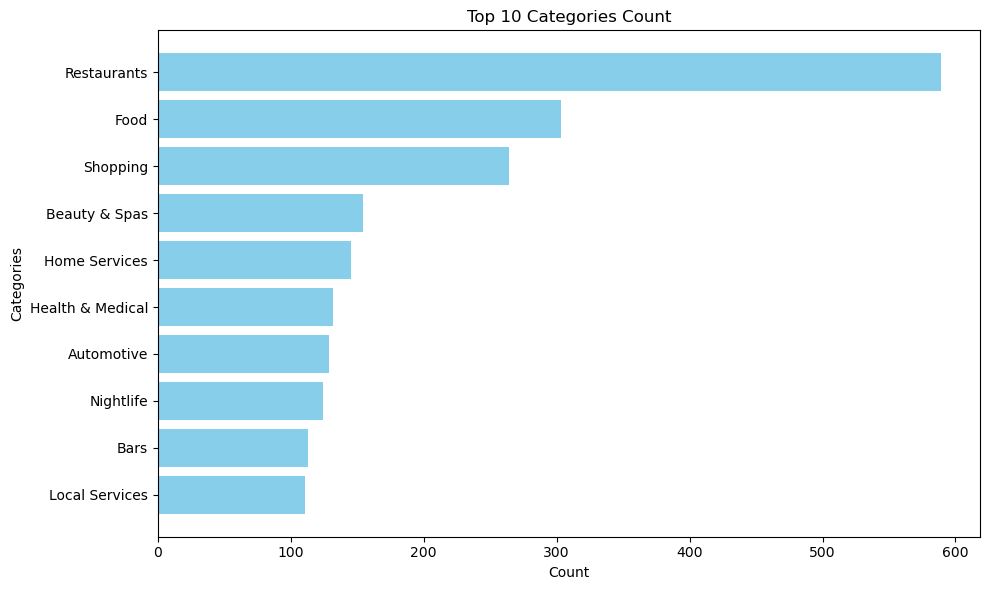

In [16]:
top_10_categories = pdf1.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_categories['categories_split'], top_10_categories['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.title('Top 10 Categories Count')
plt.gca().invert_yaxis()  
plt.tight_layout()

# Display the plot
plt.show()

In [17]:
# 3. Business Location

In [18]:
df2 = business.groupby('state').count().orderBy('count', ascending =[0])

In [19]:
fips.show()

+-----+----+
|state|fips|
+-----+----+
|   AL|  01|
|   AK|  02|
|   AZ|  04|
|   AR|  05|
|   CA|  06|
|   CO|  08|
|   CT|  09|
|   DE|  10|
|   FL|  12|
|   GA|  13|
|   HI|  15|
|   ID|  16|
|   IL|  17|
|   IN|  18|
|   IA|  19|
|   KS|  20|
|   KY|  21|
|   LA|  22|
|   ME|  23|
|   MD|  24|
+-----+----+
only showing top 20 rows



In [20]:
df2 = df2.join(fips, df2.state==fips.state, 'inner').select(df2.state, 'fips', 'count')

In [21]:
df2.show()

+-----+----+-----+
|state|fips|count|
+-----+----+-----+
|   AZ|  04|  100|
|   LA|  22|   97|
|   NJ|  34|   95|
|   NV|  32|   78|
|   ID|  16|   48|
|   CA|  06|   53|
|   DE|  10|   16|
|   MO|  29|  126|
|   IL|  17|   27|
|   WA|  53|    1|
|   IN|  18|  118|
|   TN|  47|  121|
|   PA|  42|  403|
|   FL|  12|  287|
+-----+----+-----+



In [22]:
pdf2 = df2.toPandas()
pdf2.head()

,state,fips,count
0,AZ,04,100
1,LA,22,97
2,NJ,34,95
3,NV,32,78
4,ID,16,48


In [23]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab"
fig = px.choropleth(
    pdf2,
    locations="state",  # Column containing state abbreviations
    locationmode="USA-states",       # Use USA state-level mapping
    color="count",                   # Column to determine the color intensity
    hover_name="state", # Tooltip text
    scope="usa",                     # Map scope to USA
    color_continuous_scale="Viridis", # Color scale
    title="Choropleth Map of Count of Businesses by States"
)

# Show the map
fig.show()


ModuleNotFoundError: No module named 'plotly'

In [ ]:
# Review Count Distribution
review_count_dist = business.select("review_count").rdd.flatMap(lambda x: x).histogram(10)
counts = review_count_dist[1]
bins = review_count_dist[0]

plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.title('Review Count Distribution')
plt.show()

In [ ]:
max_review_count = business.selectExpr("max(review_count) as max_review_count").collect()[0]["max_review_count"]
min_review_count = business.selectExpr("min(review_count) as min_review_count").collect()[0]["min_review_count"]
avg_review_count = business.selectExpr("avg(review_count) as avg_review_count").collect()[0]["avg_review_count"]
median_review_count = business.approxQuantile("review_count", [0.5], 0.01)[0]

print(f"Max Review Count: {max_review_count}")
print(f"Min Review Count: {min_review_count}")
print(f"Avg Review Count: {avg_review_count}")
print(f"Median Review Count: {median_review_count}")

In [ ]:
# Top 10 Review Count Business
from pyspark.sql.functions import col, expr, desc
df3 = business.orderBy(desc("review_count")).limit(10).select("name", "review_count", 'stars')

In [ ]:
df3.show(truncate = False)

In [ ]:
pdf3 = df3.toPandas()
pdf3.head()

In [ ]:
top_10_categories = pdf3.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_categories['name'], top_10_categories['review_count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Business Name')
plt.title('Top 10 Business Review Count')
plt.gca().invert_yaxis()  
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Ratings Distribution

In [ ]:
max_rating = business.selectExpr("max(stars) as max_rating").collect()[0]["max_rating"]
min_rating = business.selectExpr("min(stars) as min_rating").collect()[0]["min_rating"]
avg_rating = business.selectExpr("avg(stars) as avg_rating").collect()[0]["avg_rating"]

print(f"Max Rating: {max_rating}")
print(f"Min Rating: {min_rating}")
print(f"Avg Rating: {avg_rating}")

In [ ]:
rating_dist = business.select("stars").rdd.flatMap(lambda x: x).histogram(5)  
counts = rating_dist[1]
bins = rating_dist[0]

plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')
plt.show()

In [ ]:
top_ten_ratings = business.orderBy(desc("stars")).limit(10).select("name", "stars", 'review_count')
top_ten_ratings.show(truncate=False)

Comparing the top restaurant lists given by highest rating versus highest review counts resulted in the observation that the two criteria don’t appear to show strong correlation to each other.

In [ ]:
# So check the stars rank when review_count above average
top_ten_ratings = business.where(col('review_count') >= avg_review_count).orderBy(desc("stars")).limit(10).select("name", "stars", 'review_count')
top_ten_ratings.show(truncate=False)

In [ ]:
high_rating_city = business.filter(col("stars") >= 4.5).groupBy("city").count().orderBy(desc("count")).first()
low_rating_city = business.filter(col("stars") <= 2.5).groupBy("city").count().orderBy(desc("count")).first()

print(f"City with most high-rated businesses: {high_rating_city['city']}, Count: {high_rating_city['count']}")
print(f"City with most low-rated businesses: {low_rating_city['city']}, Count: {low_rating_city['count']}")

In [ ]:
checkin.show()
checkin.select([count(when(checkin[c].isNull(), c)).alias(c) for c in checkin.columns]).show()

In [ ]:
review.show()

In [ ]:
review.printSchema()

In [ ]:
review.select([count(when(review[c].isNull(), c)).alias(c) for c in review.columns]).show()

In [ ]:
# Top 10 users in Yelp and the quality of their reviews
review.groupby('user_id').agg({'review_id': 'count', 'useful': 'sum', 'cool': 'sum', 'funny': 'sum'}).orderBy('count(review_id)', ascending = [0]).show()

In [ ]:
tip.show(5)

In [ ]:
user.show()

In [ ]:
user.printSchema()

In [ ]:
# Total unique users
user.select('user_id').distinct().count()

In [ ]:
user.createOrReplaceTempView("user_table")

In [ ]:
res = spark.sql('SELECT (LENGTH(friends) - LENGTH(REPLACE(friends,",","")) + 1) AS `Number of Friends` from user_table')

In [ ]:
res.show()

In [ ]:
# The popularity of Yelp: # of users
# Change the format of yelping_since
from pyspark.sql.functions import to_timestamp, date_format
user_new = user.withColumn('yelping_since', to_timestamp(user['yelping_since'], 'yyyy-MM-dd hh:mm:ss a'))
user_new = user.withColumn('yelping_month', date_format('yelping_since', 'yyyy-MM'))

In [ ]:
user_new.show(3)

In [ ]:
from pyspark.sql.functions import date_sub, current_date, date_format
df_ts = df_all.where(col('Date') >= date_sub(current_date(), 365 * 3)) \
              .groupBy(date_format('Date', 'yyyy-MM').alias('Time')) \
              .count() \
              .orderBy('Time', ascending = [1])

In [ ]:
from pyspark.sql.functions import date_sub, current_date, date_format

df4 = user_new.groupBy('yelping_month').agg({'user_id': 'count'}).orderBy('yelping_month', ascending = [1])

In [ ]:
df4.show()

In [ ]:
pdf4 = df4.toPandas()

In [ ]:
pdf4.plot(kind = 'line', x = 'yelping_month', figsize = (10, 6))

In [ ]:
# pip install wordcloud

### tips

In [ ]:
tip_lis = tip.sample(0.01).select('text').collect()

In [ ]:
tip_lis = ' '.join([tip_lis[i][0] for i in range(len(tip_lis))])

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(tip_lis)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


In [ ]:
tip.groupBy('business_id').count().orderBy('count',ascending=False).show()

In [ ]:
review.groupBy('business_id').count().orderBy('count',ascending=False).show()